In [1]:
import os
import sys
import math
from copy import deepcopy

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
os.environ["CUDA_VISIBLE_DEVICES"]="5"
if torch.cuda.is_available():
    device = torch.cuda.device("cuda:5")
    use_cuda = True

In [2]:
sys.path.insert(0, 'utils/')
from MyUtils import *
from MyDatasets import *

In [3]:
# import LMRD dataset with class selection

sys.path.insert(0, '/home/m.nakhodnov/Samsung-Tasks/Datasets/LMRD/')
from LMRD import LMRDDataset

In [4]:
dataset_LMR_train = LMRDDataset(train=True, emb_size=50)
dataset_LMR_test = LMRDDataset(train=False, emb_size=50)

In [5]:
dataset_LMR_kaggle = LMRDDataset(kaggle=True, emb_size=50)

In [6]:
dataloader_LMR_train = DataLoader(dataset_LMR_train, batch_size=128, shuffle=True)
dataloader_LMR_test = DataLoader(dataset_LMR_test, batch_size=128, shuffle=True)

In [7]:
class NLPClassifier(nn.Module):
    def __init__(self, in_size):
        super(NLPClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.linear(x).view(-1)

In [8]:
class NLPClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(NLPClassifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.Tanh(),
            nn.Linear(200, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

Epoch 160... Empirical Loss/Misclassification Rate (Train): 93.073/0.000	 Empirical Loss/Misclassification Rate (Test): 92.263/0.0000

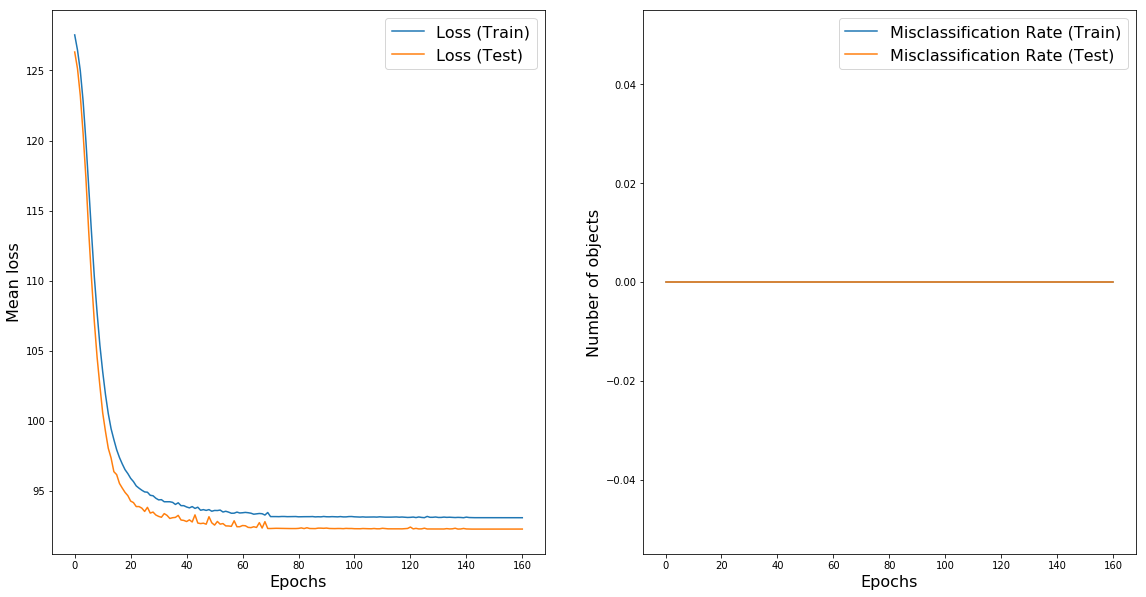

In [9]:
net_LMR_fc = NLPClassifier(50)
if use_cuda:
    net_LMR_fc = net_LMR_fc.cuda()

train_(network=net_LMR_fc, loss_func=loss_func,
       learning_rate=0.00005, reinit_optim=70,
       train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
       reg_lambda=None,
       epochs=200,
       dataloader_train=dataloader_LMR_train, dataloader_test=dataloader_LMR_test,
       )

In [ ]:
# net_LMR_fc_e = NLPClassifier_WITH_EXP(300)
# if use_cuda:
#     net_LMR_fc_e = net_LMR_fc_e.cuda()
# net_LMR_fc_e.explinear.init_weigth(0, 0.001)

# print(list(net_LMR_fc_e.explinear.named_parameters()))

train_EXP(network=net_LMR_fc_e, loss_func=loss_func_EXP,
          learning_rate=0.005, reinit_optim=700,
          train_strategy=train_strategy_STOCH, test_strategy=test_strategy_STOCH,
          reg_lambda=0.5,
          epochs=200,
          dataloader_train=dataloader_LMR_train, dataloader_test=dataloader_LMR_test,
         )

In [ ]:
net_LMR_fc_e.explinear(next(iter(dataloader_LMR_test))[0].cuda()).norm(2)

In [ ]:
net_LMR_fc_e.linear(next(iter(dataloader_LMR_test))[0].cuda()).norm(2)

In [ ]:
(1 - 2434.000 / dataset_LMR_train.__len__())

In [ ]:
(1 - 1239.000 / dataset_LMR_test.__len__())

In [ ]:
pred_shuffled = (net_LMR_fc_e(dataset_LMR_kaggle.embeddings.cuda()) > 0).float() * 2 - 1

In [ ]:
pred = torch.zeros_like(pred_shuffled)
for idx, name in enumerate(dataset_LMR_kaggle.file_names):
    id_ = int(name[:name.find('.')])
    pred[id_] = pred_shuffled[idx]

In [ ]:
import csv
with open('test_subm.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'labels'])
    for id_, res in enumerate(pred):
        spamwriter.writerow([id_, int(res) if int(res) == 1 else 0])